# Predict Protein Contact Map

Let's say you want to securely generate a fast but accurate contact map for visualization or ML. BioLM lets you [predict the contact map data](https://api.biolm.ai/#6c68eb47-8e79-4785-aa8f-f0cb1a31ef13) in seconds, no spinning up GPUs or installing programs and dependencies.

In [1]:
BIOLMAI_TOKEN = " "  # YOUR TOKEN GOES HERE!! Get one at https://biolm.ai

## Define Endpoint Params

In [2]:
# Let's use the sequence from the paper
# https://www.biorxiv.org/content/10.1101/2021.07.09.450648v2.full.pdf
SEQ = "ASKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

print("Sequence length: {}".format(len(SEQ)))

Sequence length: 238


In [3]:
SLUG = 'esm2_t33_650M_UR50D'  # Model endpoint to hit on BioLM.ai
ACTION = 'transform'

# Follow the link to the docs for the endpoint above to see this definition
data = {
  "instances": [{
    "data": {"text": SEQ}
  }]
}

## Make API Request

Let's make a secure REST API request to BioLM API to quickly make the prediction on GPU.

In [4]:
from IPython.display import JSON  # Helpful UI for JSON display

try:
    # Install packages to make API requests in JLite
    import micropip
    await micropip.install('requests')
    await micropip.install('pyodide-http')
    # Patch requests for in-browser support
    import pyodide_http
    pyodide_http.patch_all()
    await micropip.install('matplotlib')
except ModuleNotFoundError:
    pass  # Won't be using micropip outside of JLite

import requests  # Will use to make calls to BioLM.ai
import time

In [5]:
url = f"https://biolm.ai/api/v1/models/{SLUG}/{ACTION}/"

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Token {BIOLMAI_TOKEN.strip()}",
}

In [6]:
s = time.time()  # Start time

# Make the request!
response = requests.post(
    url=url,
    headers=headers,
    json=data,
)

result = response.json()

e = time.time()  # End time
d = e - s  # Duration

print(f'Response time: {d:.4}s')

Response time: 0.718s


In [7]:
from IPython.display import JSON

JSON(result)

<IPython.core.display.JSON object>

Since the model is already hot (loaded into memory on a GPU server in the cloud), it takes about 2 sec to get several pertinent sequence representations from ESM2. There are keys containing:

 * our `contacts`, which is a `len(seq) x len(seq)` matrix
 * the `logits` from the final hidden state, which is a vector of `len(seq)`
 * the `attentions` or attention map, which is `len(seq) x n_layers`
 * `mean_representations`, which are the protein embeddings which is a vector of `1280`
 * lastly `name`, which is simply the index of the sequence in the order it was POSTed

In [8]:
preds = result['predictions'][0]
contact_map = preds['contacts']

# Straight from the model, this would be 223, 223 due to start/end tokens,
# but the endpoint cleans that up for us
nrow = len(contact_map)
ncol = len(contact_map[0])

print(f'({nrow}, {ncol})')

(238, 238)


In [9]:
from matplotlib import pyplot as plt

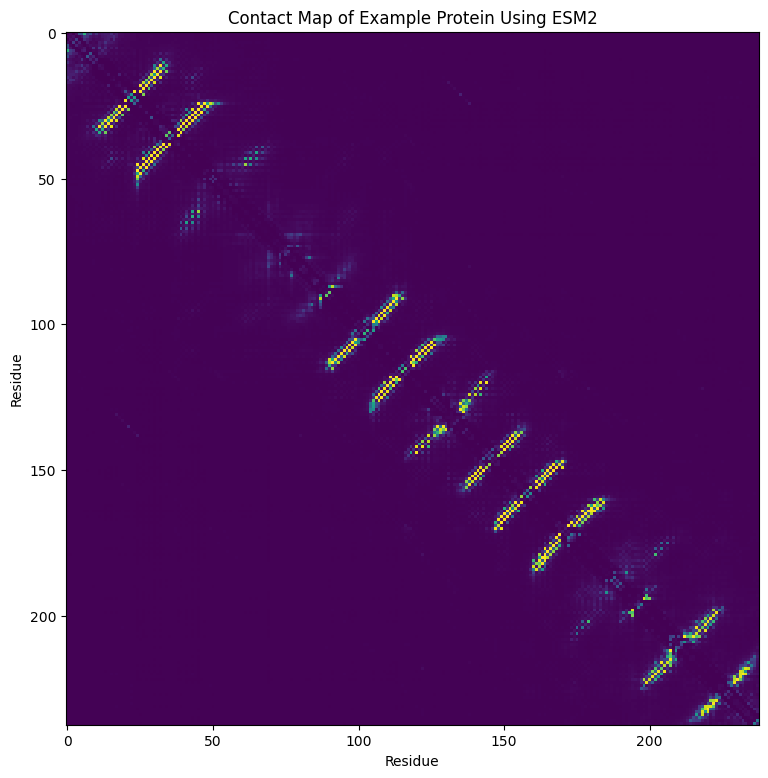

In [10]:
plt.figure(figsize=(9, 9))
plt.xlabel('Residue')
plt.ylabel('Residue')
plt.title('Contact Map of Example Protein Using ESM2')
plt.imshow(contact_map, cmap='viridis', interpolation='nearest')
plt.show()